In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
from itertools import combinations
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## 1. Visualise distributions

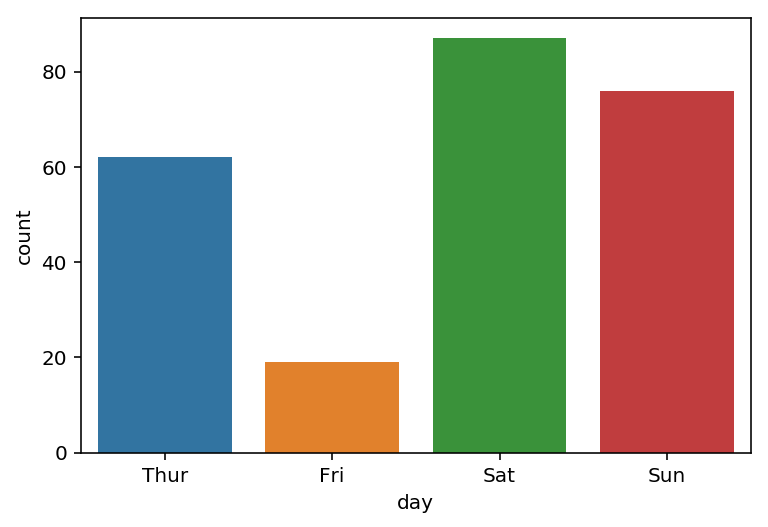

In [3]:
sns.countplot(x="day", data=tips)

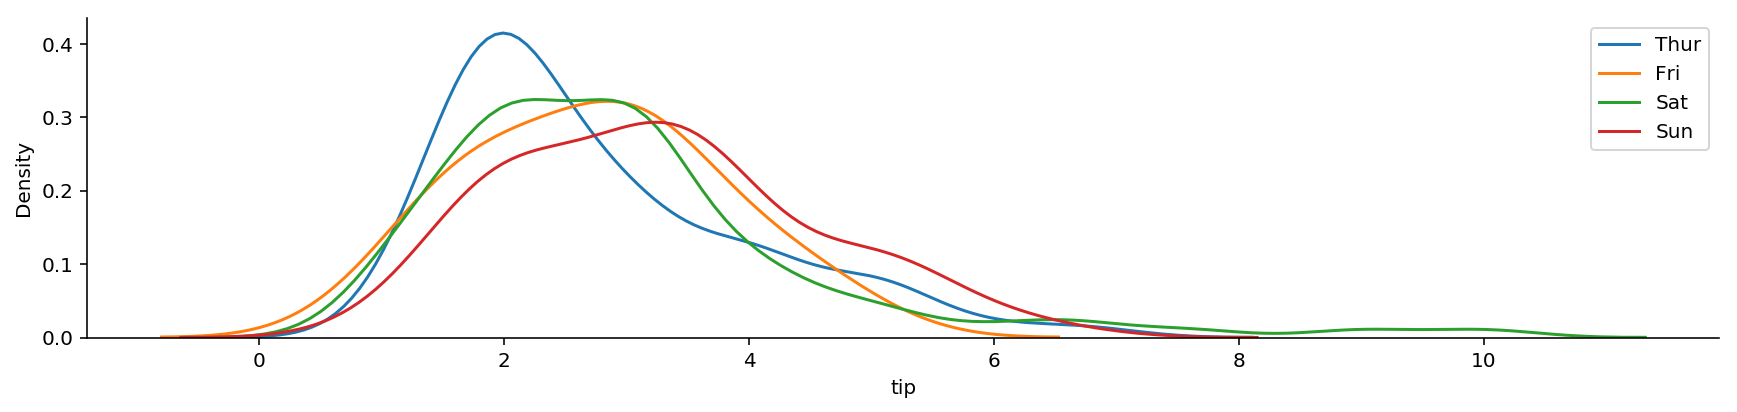

In [4]:
unique_day = tips['day'].unique()
g = sns.FacetGrid(tips, hue="day", aspect=4.)  # row='day', 
g.map(sns.distplot, "tip", hist=False, rug=False)
g.ax.legend()
g.ax.set_ylabel('Density')
plt.show()

## 2. Set up model

- Model tip distribution with a Gamma distribution is suitable in this scenario because 
  - Values of tip are always zero or positive
  - A tip distribution can be skewed, usually positively skewed
- Without other knowledge, weakly informative priors will be specified
  - `mu`: Exponential, because the mean of a tip distribution is zero or positive and it is unsure what the upper limit is but a tip is unlikely to be very high (from personal experience). Therefore set the mean of this Exponential distribution as `1/tip.mean()`.
  - `sigma`: Exponential, because standard deviation must be positive. Setting the mean of this Exponential distribution as `1/(10*tip.std())` provides a wide / weakly informative prior.

In [5]:
tip = tips['tip'].values
categories = pd.Categorical(tips['day'])
idx = categories.codes

In [6]:
samples = 5000
burn = 500

In [7]:
with pm.Model() as comparing_groups:
    mu = pm.Exponential('mu', lam=1 / tip.mean(), shape=categories.categories.size)
    sigma = pm.Exponential('sigma', lam=1/(10 * tip.std()), shape=categories.categories.size)
    y = pm.Gamma('y', mu=mu[idx], sigma=sigma[idx], observed=tip)
    
    trace_cg = pm.sample(samples, chains=4, cores=4)
    chain_cg = trace_cg[burn:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:12<00:00, 1694.85draws/s]


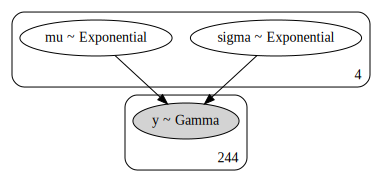

In [14]:
pm.model_to_graphviz(comparing_groups)

## 3. Check convergence

### 3.1 Graphical inspection of convergence
  - KDE plots (left) should be smooth and tend to become Gaussian like (central limit theorem)
  - Trace plots (right) should look like white noise i.e. no recognisable patterns
  - Parallel chains are independent of each other. All chains should look similar to each other

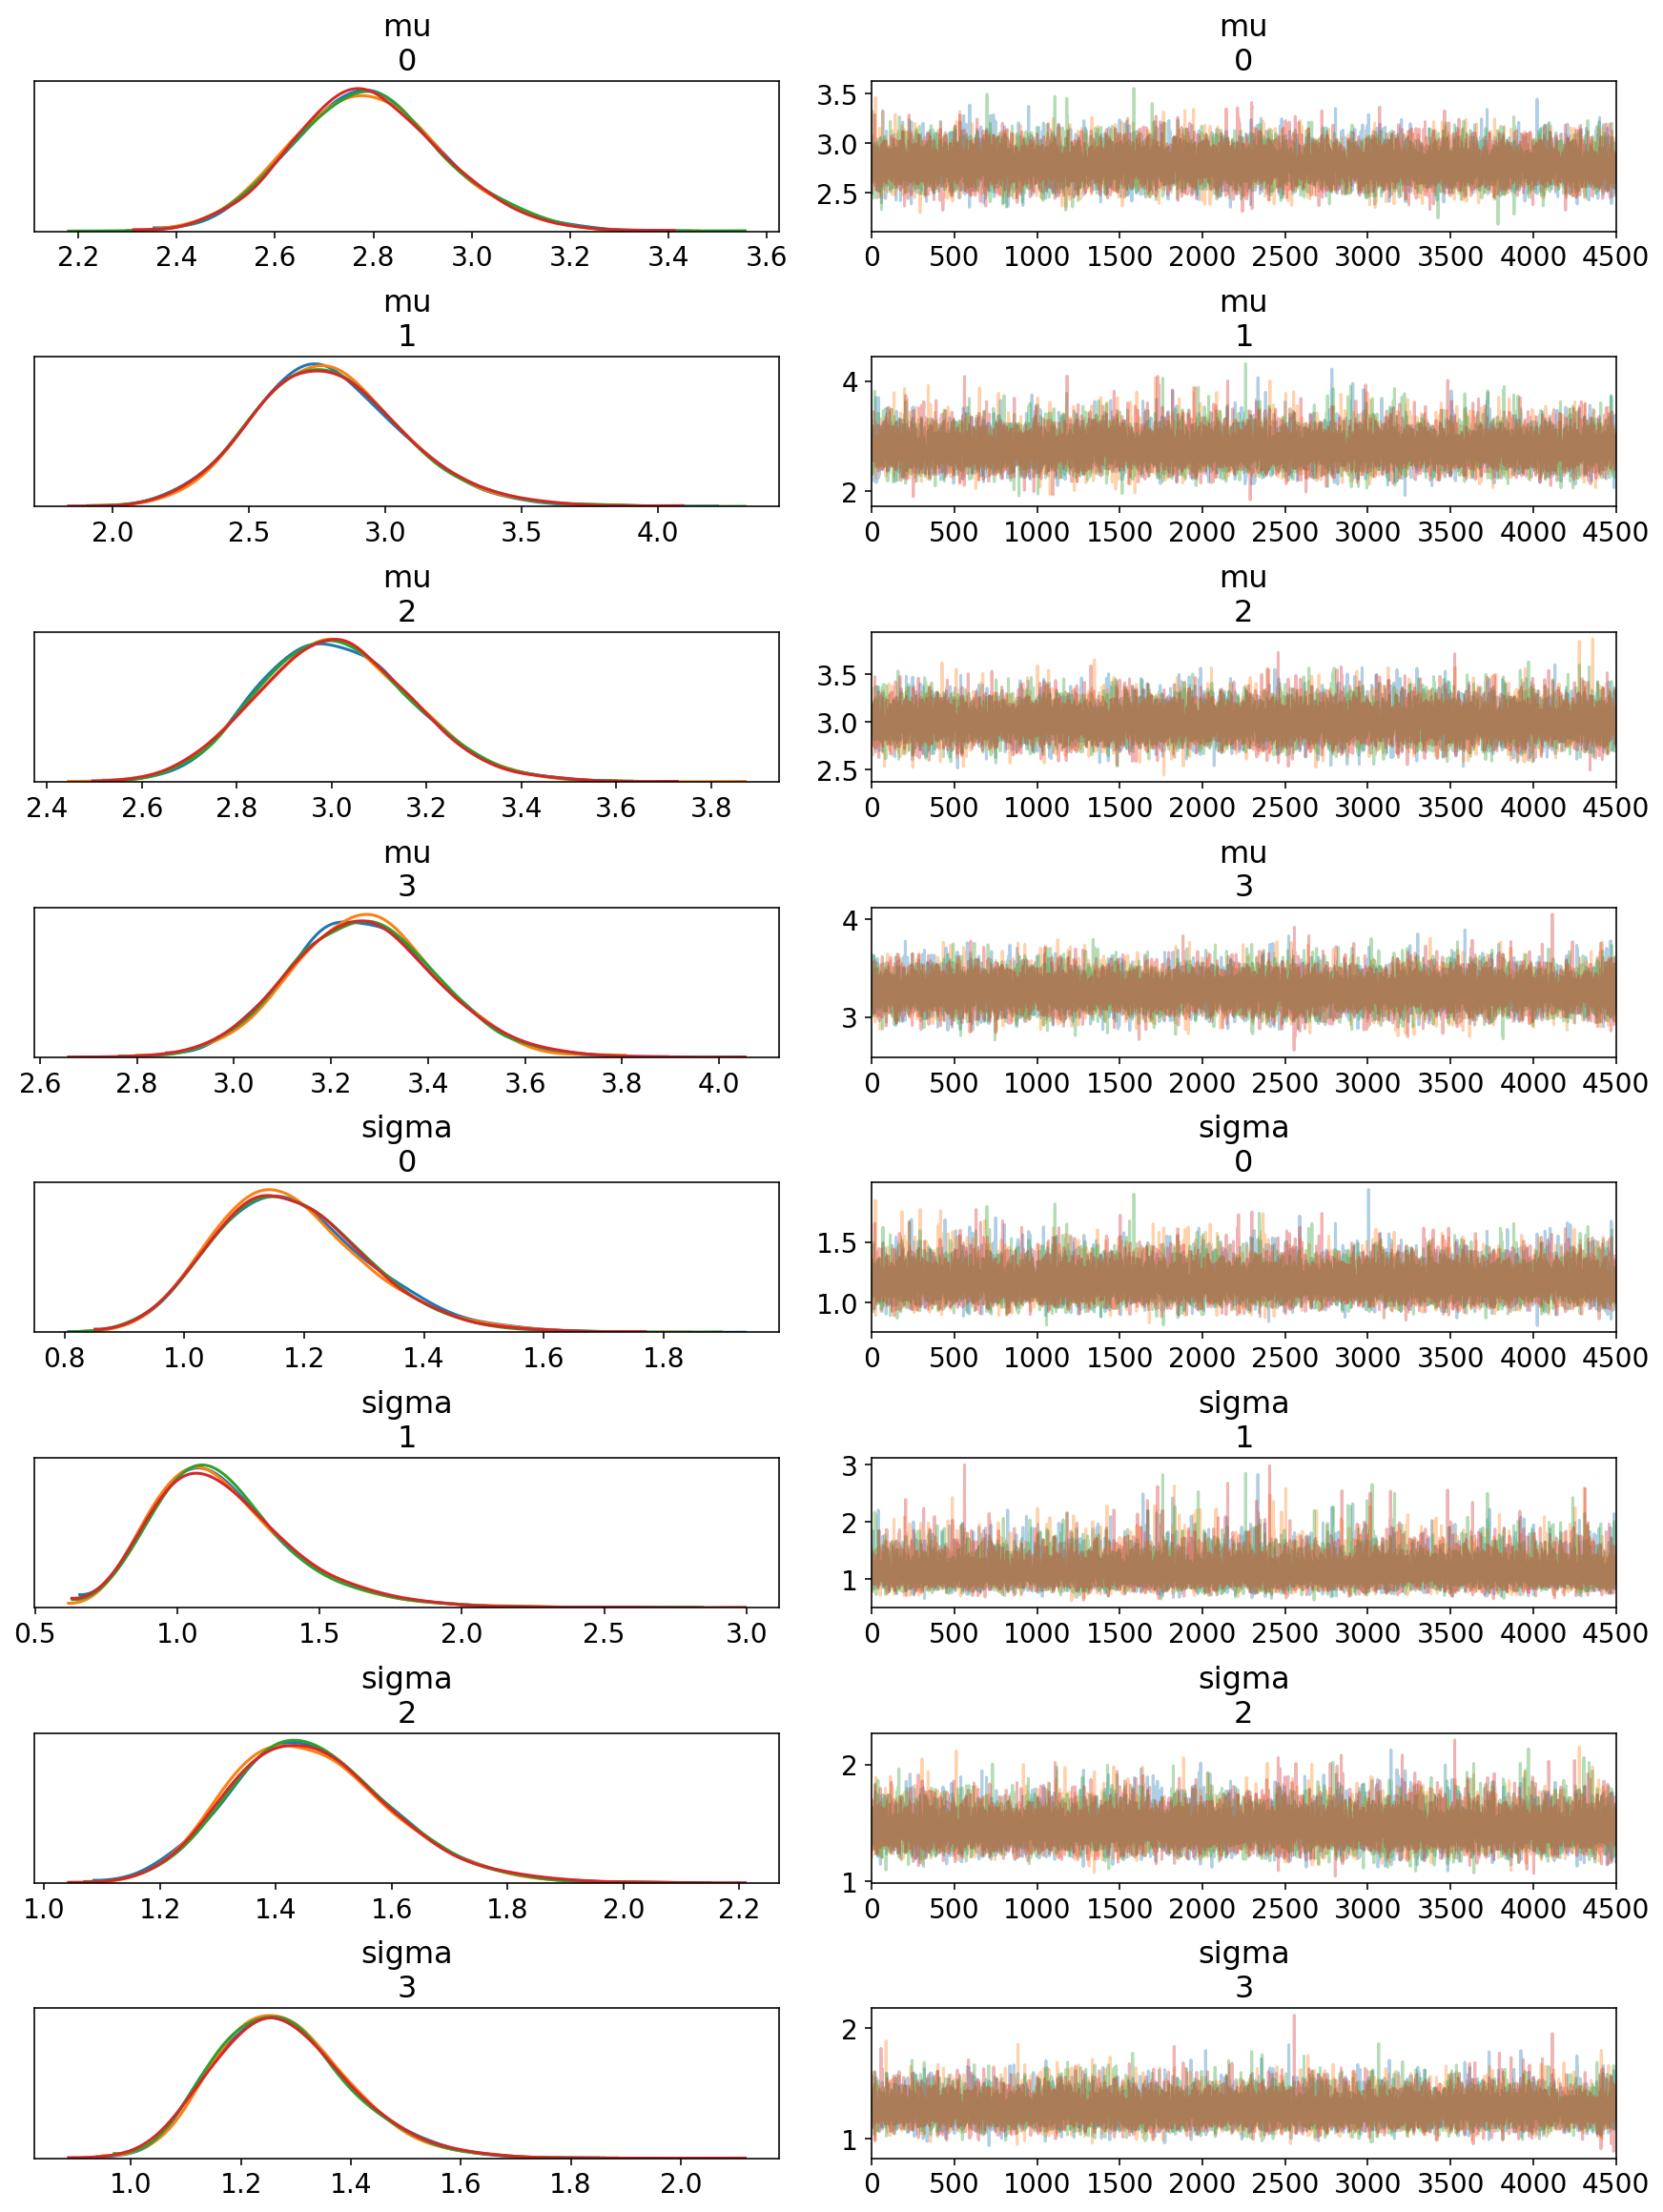

In [8]:
_ = pm.traceplot(chain_cg)

### 3.2 Quantitative measure of convergence
  - Use Gelman-Rubin test to test for convergence. Ideally, we should expect the Gelman-Rubin statistic is be around 1.

In [9]:
pm.gelman_rubin(chain_cg)

{'mu': array([1.00004785, 0.99999698, 0.99991029, 0.99993583]),
 'sigma': array([1.00005963, 0.99998374, 1.00000336, 0.99995766])}

## 4. Check error introduced by sampling

- Check estimation of error introduced by the sampling method (`mc_error` in table below) which takes into account that samples are not truly independent of each other. 
- `mc_error` should be small compared to `sd`

In [10]:
pm.summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,2.787856,0.151696,0.001161,2.507339,3.101845,17546.552427,1.000048
mu__1,2.787364,0.273539,0.001973,2.264965,3.332837,17149.697779,0.999997
mu__2,3.006965,0.158282,0.001216,2.694055,3.308354,17531.581142,0.999910
mu__3,3.266473,0.148034,0.000987,2.981077,3.557905,18969.798172,0.999936
sigma__0,1.177907,0.126280,0.000968,0.954212,1.434467,17545.345268,1.000060
sigma__1,1.162586,0.246698,0.001881,0.759111,1.666969,14365.483870,0.999984
sigma__2,1.460994,0.136011,0.001031,1.214259,1.738396,17562.557943,1.000003
sigma__3,1.275452,0.119928,0.000809,1.060356,1.517275,19004.812452,0.999958


## 5. Check autocorrelation 

- A chain should have insignificant autocorrelation, each point should be independent of another
- With some MCMC methods, samples can be autocorrelated

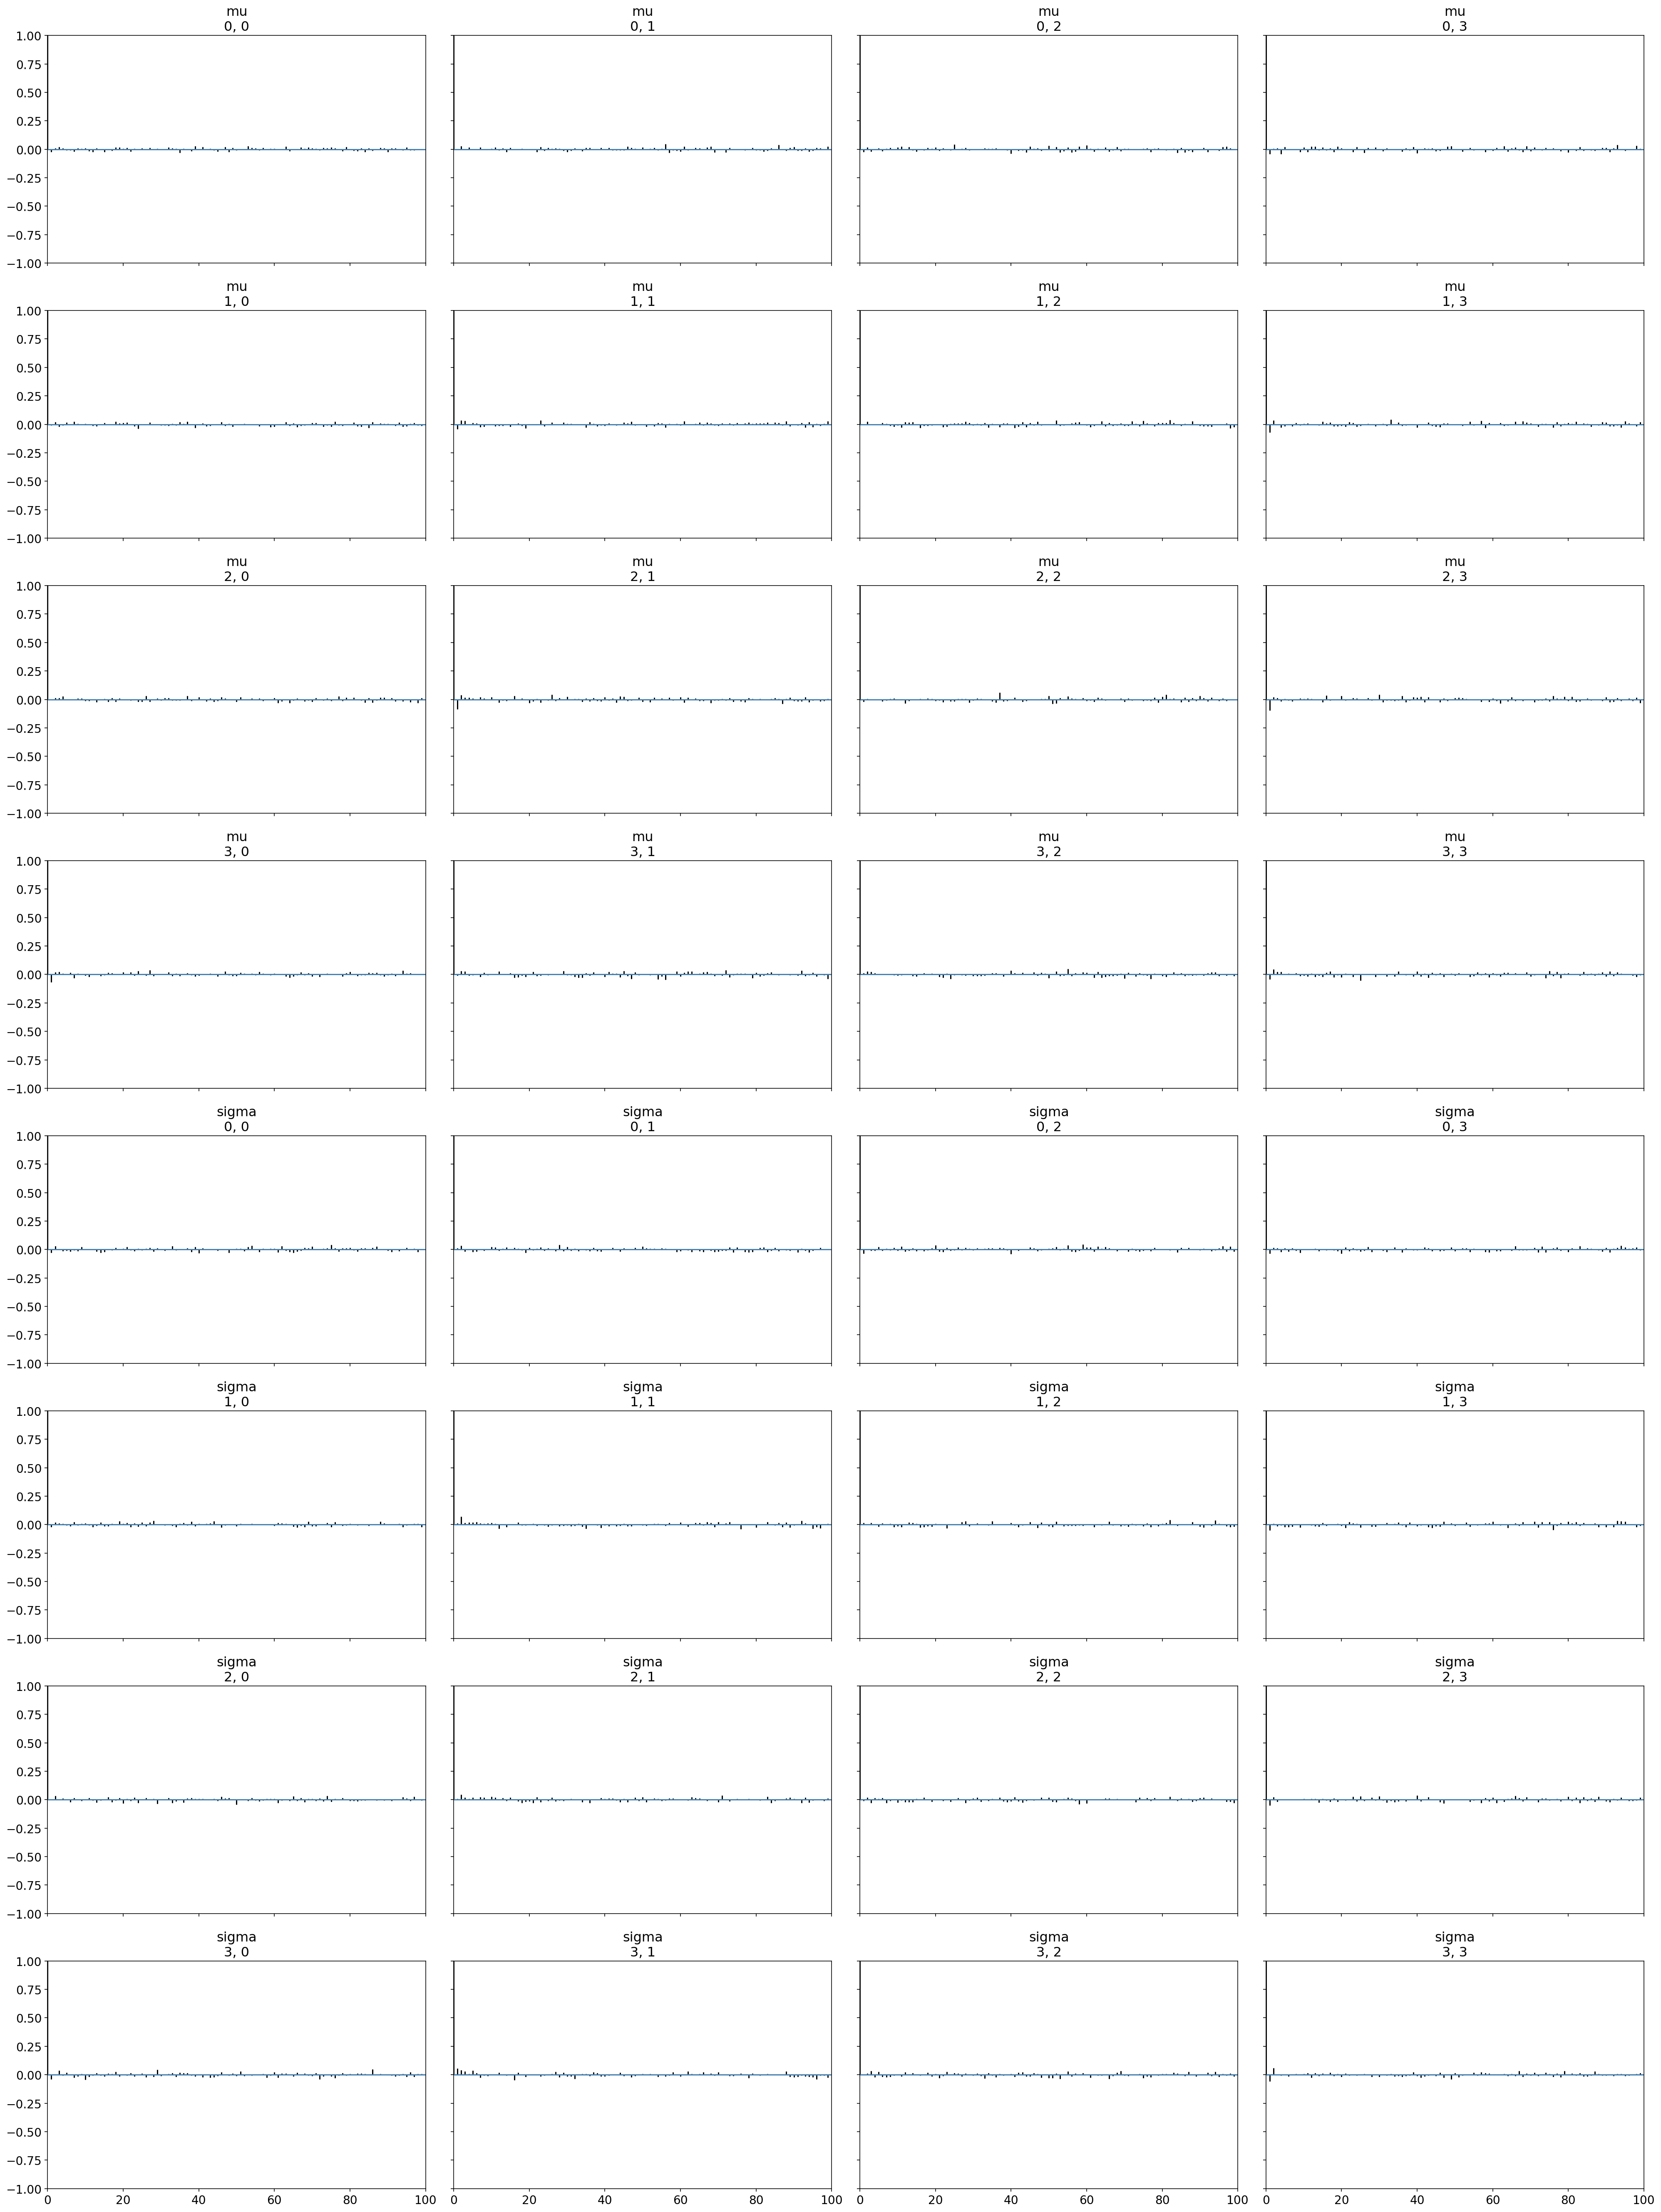

In [11]:
pm.autocorrplot(chain_cg)
plt.show()

## 6. Compare groups

- The difference in means is evaluated here. As the model is specified with `mu`, the means can be conveniently extracted.
- ROPE is used to make decisions. Here the size of the ROPE is between -\$5 and \$5. This means that within +/- \$5 difference, the decision will be said as practically equivalent.
- Looking at the following graphs, we can conclude that the tip distributions are practically equivalent between Thur, Fri, Sat and Sun
- Although the 95\% HPD crosses the zero in "Thur vs Sun", it is "small" in the practical sense.

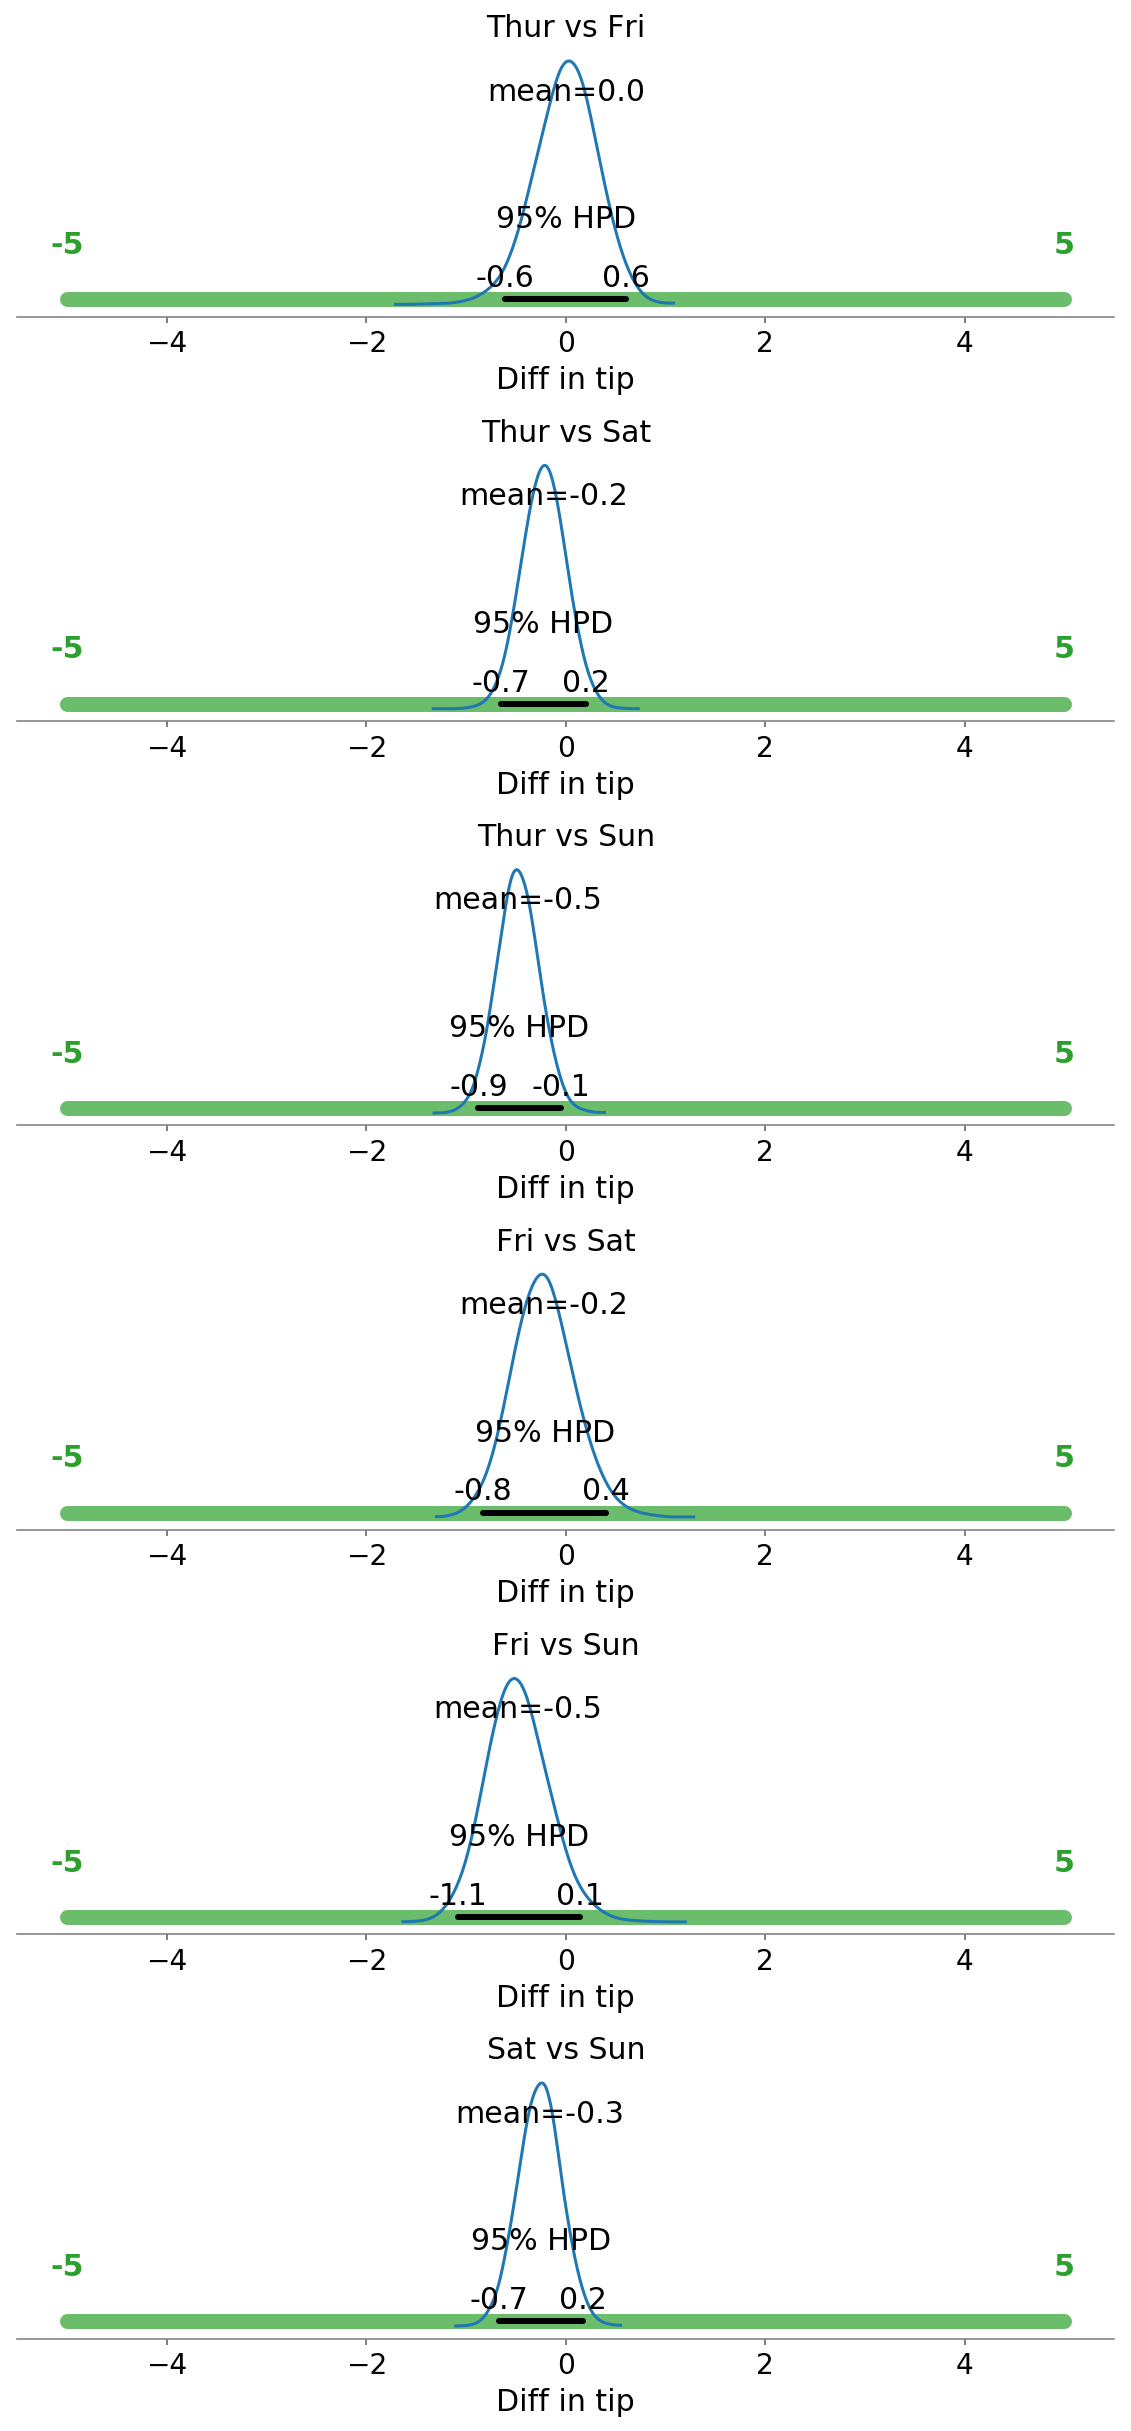

In [12]:
means_diff = []
pairs = list(combinations(set(idx), 2))
fig, ax = plt.subplots(len(pairs), 1, figsize=(8, 17), sharex=True)

for n, (i, j) in enumerate(pairs):
    d = chain_cg['mu'][:, i] - chain_cg['mu'][:, j]
    means_diff.append(d)
    pm.plot_posterior(d, rope=(-5, 5), credible_interval=0.95, ax=ax[n])
    ax[n].set_xlabel('Diff in tip', fontdict={'fontsize': 15})
    ax[n].set_title(f'{categories.categories[i]} vs {categories.categories[j]}', fontdict={'fontsize': 15})
    
fig.tight_layout()